# Baseline Models - Train, Compare & Predict

Trains all 9 baseline models (17 configs), compares RMSE/accuracy,
tunes hyperparameters, builds an ensemble, and generates Round 1 predictions.

**Run all cells top-to-bottom with Shift+Enter.**

## 1. Setup

In [1]:
import sys, os, pathlib

# Reliably set cwd to the python/ folder (parent of training/)
_nb_dir = pathlib.Path(os.path.abspath('')).resolve()
_python_dir = _nb_dir.parent  # python/
os.chdir(_python_dir)
sys.path.insert(0, str(_python_dir))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils.baseline_model import (
    GlobalMeanBaseline, TeamMeanBaseline, HomeAwayBaseline,
    MovingAverageBaseline, WeightedHistoryBaseline, PoissonBaseline,
    DixonColesBaseline, BayesianTeamBaseline, EnsembleBaseline,
    compare_baselines
)

print(f'CWD: {os.getcwd()}')
print('Imports OK')

CWD: C:\Users\iscur\code\smiles\CSVy_wharton\python
Imports OK


c:\Users\iscur\code\smiles\CSVy_wharton\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Load WHL Data

In [2]:
df = pd.read_csv('data/whl_2025.csv')

# Aggregate shifts to game-level (one row per game)
games = df.groupby('game_id').agg(
    home_team=('home_team', 'first'),
    away_team=('away_team', 'first'),
    home_goals=('home_goals', 'first'),
    away_goals=('away_goals', 'first')
).reset_index()

# Sort chronologically
games['game_num'] = games['game_id'].str.extract(r'(\d+)').astype(int)
games = games.sort_values('game_num').reset_index(drop=True)

# 80/20 split
split = int(len(games) * 0.8)
train_df = games.iloc[:split].copy()
test_df  = games.iloc[split:].copy()

print(f'{len(games)} games  |  Train: {len(train_df)}  |  Test: {len(test_df)}')
print(f'Home win rate: {(games["home_goals"] > games["away_goals"]).mean():.1%}')
games.head()

1312 games  |  Train: 1049  |  Test: 263
Home win rate: 11.4%


,game_id,home_team,away_team,home_goals,away_goals,game_num
0,game_1,thailand,pakistan,0,1,1
1,game_2,france,morocco,0,1,2
2,game_3,peru,iceland,0,1,3
3,game_4,mongolia,saudi_arabia,0,0,4
4,game_5,usa,guatemala,1,0,5


## 3. Train All 17 Configurations

In [3]:
configs = {
    'GlobalMean':         GlobalMeanBaseline(),
    'TeamMean':           TeamMeanBaseline(),
    'HomeAway':           HomeAwayBaseline(),
    'MovingAvg(5)':       MovingAverageBaseline({'window': 5}),
    'MovingAvg(10)':      MovingAverageBaseline({'window': 10}),
    'MovingAvg(20)':      MovingAverageBaseline({'window': 20}),
    'WeightedHist(0.9)':  WeightedHistoryBaseline({'decay': 0.9}),
    'WeightedHist(0.95)': WeightedHistoryBaseline({'decay': 0.95}),
    'WeightedHist(0.99)': WeightedHistoryBaseline({'decay': 0.99}),
    'Poisson':            PoissonBaseline(),
    'DixonColes(0.95)':   DixonColesBaseline({'decay': 0.95}),
    'DixonColes(0.99)':   DixonColesBaseline({'decay': 0.99}),
    'DixonColes(1.0)':    DixonColesBaseline({'decay': 1.0}),
    'Bayesian(5)':        BayesianTeamBaseline({'prior_weight': 5}),
    'Bayesian(10)':       BayesianTeamBaseline({'prior_weight': 10}),
    'Bayesian(20)':       BayesianTeamBaseline({'prior_weight': 20}),
    'Bayesian(50)':       BayesianTeamBaseline({'prior_weight': 50}),
}

for name, model in configs.items():
    model.fit(train_df)
    print(f'  Trained {name}')

print(f'\nAll {len(configs)} configs trained.')

  Trained GlobalMean
  Trained TeamMean
  Trained HomeAway
  Trained MovingAvg(5)
  Trained MovingAvg(10)
  Trained MovingAvg(20)
  Trained WeightedHist(0.9)
  Trained WeightedHist(0.95)
  Trained WeightedHist(0.99)
  Trained Poisson
  Trained DixonColes(0.95)
  Trained DixonColes(0.99)
  Trained DixonColes(1.0)
  Trained Bayesian(5)
  Trained Bayesian(10)
  Trained Bayesian(20)
  Trained Bayesian(50)

All 17 configs trained.


## 4. Compare Performance

In [4]:
results = []
for name, model in configs.items():
    metrics = model.evaluate(test_df)
    results.append({'model': name, **metrics})

results_df = pd.DataFrame(results).sort_values('combined_rmse')
print(results_df[['model', 'combined_rmse', 'rmse', 'away_rmse', 'win_accuracy']].to_string(index=False))

             model  combined_rmse      rmse  away_rmse  win_accuracy
        GlobalMean       0.440313  0.520682   0.341529      0.125475
          TeamMean       0.441798  0.522114   0.343175      0.490494
      Bayesian(50)       0.442082  0.523696   0.341491      0.304183
WeightedHist(0.99)       0.442171  0.523067   0.342682      0.505703
          HomeAway       0.443839  0.524834   0.344289      0.403042
      Bayesian(20)       0.444468  0.526910   0.342739      0.323194
WeightedHist(0.95)       0.444595  0.527446   0.342242      0.475285
      Bayesian(10)       0.446088  0.529050   0.343649      0.349810
     MovingAvg(20)       0.446605  0.529868   0.343731      0.513308
       Bayesian(5)       0.447211  0.530524   0.344295      0.353612
           Poisson       0.448048  0.532871   0.342845      0.288973
 WeightedHist(0.9)       0.448356  0.532907   0.343594      0.452471
     MovingAvg(10)       0.455115  0.540745   0.349075      0.482890
   DixonColes(1.0)       0.455552 

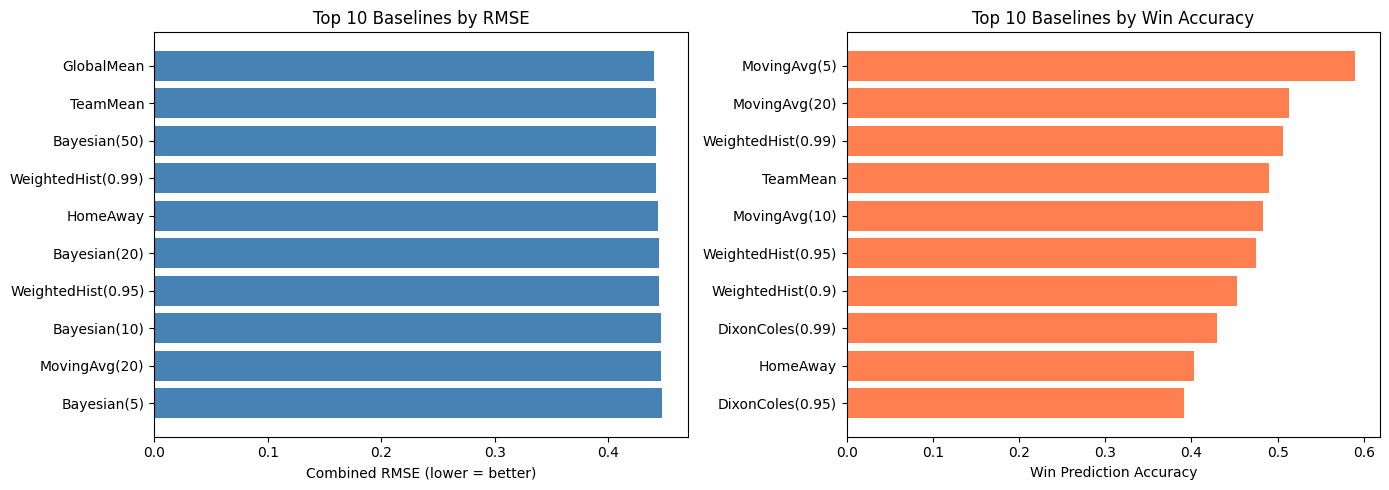

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

top = results_df.head(10)
axes[0].barh(top['model'], top['combined_rmse'], color='steelblue')
axes[0].set_xlabel('Combined RMSE (lower = better)')
axes[0].set_title('Top 10 Baselines by RMSE')
axes[0].invert_yaxis()

top_acc = results_df.sort_values('win_accuracy', ascending=False).head(10)
axes[1].barh(top_acc['model'], top_acc['win_accuracy'], color='coral')
axes[1].set_xlabel('Win Prediction Accuracy')
axes[1].set_title('Top 10 Baselines by Win Accuracy')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

## 5. Hyperparameter Tuning

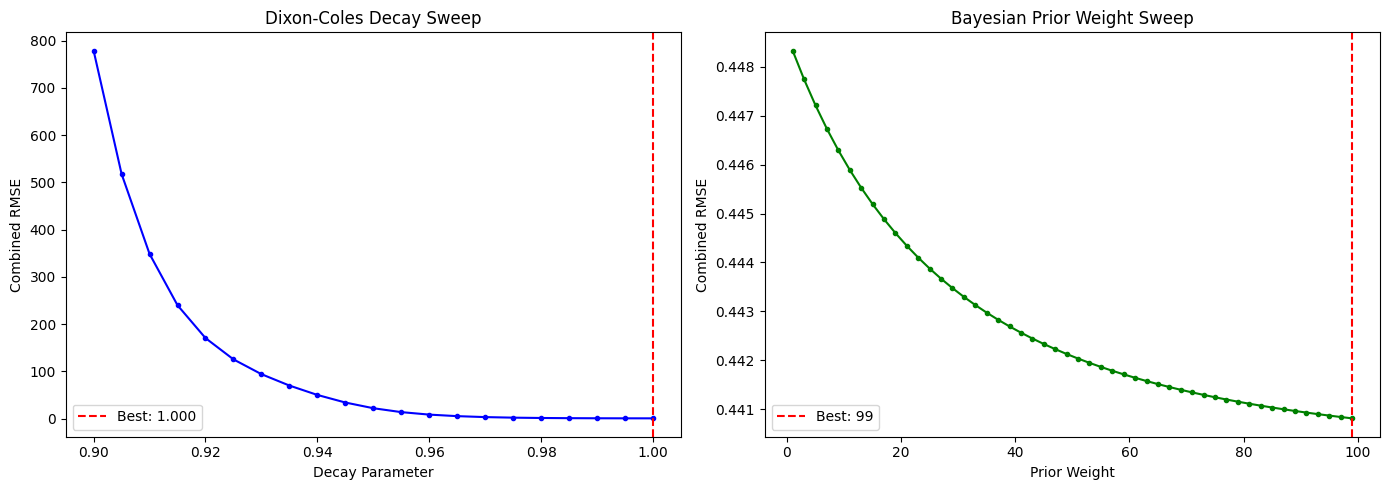

Best Dixon-Coles decay: 1.000 (RMSE 0.4556)
Best Bayesian prior_weight: 99 (RMSE 0.4408)


In [6]:
# Sweep Dixon-Coles decay (must be <= 1.0 to avoid overflow)
dc_decays = np.arange(0.90, 1.001, 0.005)
dc_rmses = []
for d in dc_decays:
    m = DixonColesBaseline({'decay': round(d, 4)})
    m.fit(train_df)
    dc_rmses.append(m.evaluate(test_df)['combined_rmse'])

# Sweep Bayesian prior_weight
bw_weights = np.arange(1, 101, 2)
bw_rmses = []
for w in bw_weights:
    m = BayesianTeamBaseline({'prior_weight': w})
    m.fit(train_df)
    bw_rmses.append(m.evaluate(test_df)['combined_rmse'])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(dc_decays, dc_rmses, 'b.-')
best_dc = dc_decays[np.argmin(dc_rmses)]
axes[0].axvline(best_dc, color='r', linestyle='--', label=f'Best: {best_dc:.3f}')
axes[0].set_xlabel('Decay Parameter')
axes[0].set_ylabel('Combined RMSE')
axes[0].set_title('Dixon-Coles Decay Sweep')
axes[0].legend()

axes[1].plot(bw_weights, bw_rmses, 'g.-')
best_bw = bw_weights[np.argmin(bw_rmses)]
axes[1].axvline(best_bw, color='r', linestyle='--', label=f'Best: {best_bw}')
axes[1].set_xlabel('Prior Weight')
axes[1].set_ylabel('Combined RMSE')
axes[1].set_title('Bayesian Prior Weight Sweep')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f'Best Dixon-Coles decay: {best_dc:.3f} (RMSE {min(dc_rmses):.4f})')
print(f'Best Bayesian prior_weight: {best_bw} (RMSE {min(bw_rmses):.4f})')

## 6. Build Ensemble

In [7]:
ensemble = EnsembleBaseline({'models': [
    HomeAwayBaseline(),
    PoissonBaseline(),
    DixonColesBaseline({'decay': best_dc}),
    BayesianTeamBaseline({'prior_weight': int(best_bw)}),
]})
ensemble.fit(train_df)
ens_metrics = ensemble.evaluate(test_df)

print(f'Ensemble RMSE:         {ens_metrics["combined_rmse"]:.4f}')
print(f'Ensemble Win Accuracy: {ens_metrics["win_accuracy"]:.1%}')

Ensemble RMSE:         0.4452
Ensemble Win Accuracy: 31.9%


## 7. Round 1 Predictions

In [8]:
matchups = pd.read_excel('data/WHSDSC_Rnd1_matchups.xlsx')
print(f'{len(matchups)} matchups loaded')
matchups.head()

16 matchups loaded


,game,game_id,home_team,away_team
0,1,game_1,brazil,kazakhstan
1,2,game_2,netherlands,mongolia
2,3,game_3,peru,rwanda
3,4,game_4,thailand,oman
4,5,game_5,pakistan,germany


In [9]:
# Re-fit on ALL data for final predictions
final_ensemble = EnsembleBaseline({'models': [
    HomeAwayBaseline(),
    PoissonBaseline(),
    DixonColesBaseline({'decay': best_dc}),
    BayesianTeamBaseline({'prior_weight': int(best_bw)}),
]})
final_ensemble.fit(games)

home_col = [c for c in matchups.columns if 'home' in c.lower()][0]
away_col = [c for c in matchups.columns if 'away' in c.lower()][0]

predictions = []
for _, row in matchups.iterrows():
    game = {'home_team': row[home_col], 'away_team': row[away_col]}
    h_goals, a_goals = final_ensemble.predict_goals(game)
    winner, conf = final_ensemble.predict_winner(game)
    predictions.append({
        'home_team': game['home_team'], 'away_team': game['away_team'],
        'pred_home': round(h_goals, 2), 'pred_away': round(a_goals, 2),
        'winner': winner, 'confidence': f'{conf:.1%}'
    })

pred_df = pd.DataFrame(predictions)
print(pred_df.to_string(index=False))

  home_team    away_team  pred_home  pred_away      winner confidence
     brazil   kazakhstan       0.34       0.07      brazil      81.8%
netherlands     mongolia       0.27       0.06 netherlands      83.0%
       peru       rwanda       0.19       0.07        peru      72.3%
   thailand         oman       0.37       0.11    thailand      77.4%
   pakistan      germany       0.26       0.09    pakistan      73.7%
      india          usa       0.39       0.11       india      77.9%
     panama  switzerland       0.19       0.08      panama      69.7%
    iceland       canada       0.12       0.14      canada      54.2%
      china       france       0.29       0.11       china      73.2%
philippines      morocco       0.09       0.08 philippines      52.9%
   ethiopia saudi_arabia       0.11       0.04    ethiopia      71.9%
  singapore  new_zealand       0.21       0.14   singapore      59.7%
  guatemala  south_korea       0.19       0.19 south_korea      50.2%
         uk       me

## 8. Save Results

In [10]:
os.makedirs('output/predictions', exist_ok=True)
results_df.to_csv('output/baseline_comparison.csv', index=False)
pred_df.to_csv('output/predictions/round1_baseline_predictions.csv', index=False)
final_ensemble.save_model('output/best_baseline.pkl')

print('Saved:')
print('  output/baseline_comparison.csv')
print('  output/predictions/round1_baseline_predictions.csv')
print('  output/best_baseline.pkl')

Saved:
  output/baseline_comparison.csv
  output/predictions/round1_baseline_predictions.csv
  output/best_baseline.pkl
